# Semantic Segmentation on Cityscapes Using a Fine-Tuned SegFormer Model

Semantic segmentation plays an important role in understanding urban environments, especially in applications such as autonomous driving, mapping, and infrastructure analysis. Accurate segmentation allows systems to distinguish roads, sidewalks, buildings, vehicles, and pedestrians at the pixel level, providing a detailed understanding of the scene.

This project explores semantic segmentation on the Cityscapes dataset using a pretrained SegFormer model from the HuggingFace model hub. SegFormer combines transformer-based feature extraction with a lightweight decoder, making it efficient while maintaining strong performance. The goal of this project is to fine-tune the model on Cityscapes and evaluate its ability to segment common urban objects. Data augmentation and hyperparameter tuning are applied to improve generalization and segmentation quality.

The dataset used in this project contains high-resolution street-view images with pixel-level annotations for 19 semantic classes. We evaluate the model on both pixel accuracy and mean Intersection-over-Union (mIoU), and visualize segmentation results to assess qualitative performance.

### Table of contents of this notebook:

1. [Importing necessary libraries](#1.-Importing-necessary-libraries)

2. [Loading data](#2.-Loading-data)

3. [Data pre-processing](#3.-Data-pre-processing)

4. [Model Fine tuning](#4.-Model-Fine-tuning)



# 1. Importing necessary libraries

In [1]:
#pip install datasets    #you have to make sure install this first for loading the data from huggingFace
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from transformers import SegformerConfig, SegformerForSemanticSegmentation
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, concatenate_datasets, DatasetDict
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch.nn as nn

/home/cuixing/.conda/envs/seg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Loading data

In [2]:
ds = load_dataset(
    "tanganke/cityscapes",
    cache_dir="/scratch/mdp_umtri_project_root/mdp_umtri_project1/cuixing"   
)
train_ds = ds["train"]
val_ds = ds["validation"]

sample = train_ds[0]
image = np.array(sample["image"])           
mask19 = np.array(sample["segmentation_19"]) 
print("Dataset size:", ds.shape)

Using the latest cached version of the dataset since tanganke/cityscapes couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /scratch/mdp_umtri_project_root/mdp_umtri_project1/cuixing/tanganke___cityscapes/default/0.0.0/9489fa78507f939420ccb72670132c622180ccbf (last modified on Mon Dec  1 21:47:30 2025).


Dataset size: {'train': (2975, 5), 'validation': (500, 5)}


In [3]:
unique, counts = np.unique(mask19, return_counts=True)
print("Mask class distribution:", dict(zip(unique, counts)))

Mask class distribution: {np.float64(-1.0): np.int64(2272), np.float64(0.0): np.int64(12848), np.float64(1.0): np.int64(439), np.float64(2.0): np.int64(9467), np.float64(5.0): np.int64(380), np.float64(7.0): np.int64(537), np.float64(8.0): np.int64(3436), np.float64(9.0): np.int64(2043), np.float64(10.0): np.int64(607), np.float64(11.0): np.int64(20), np.float64(12.0): np.int64(39), np.float64(13.0): np.int64(643), np.float64(18.0): np.int64(37)}


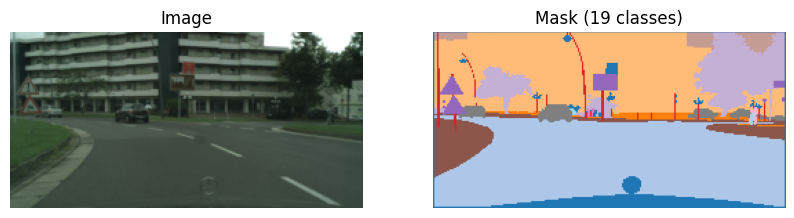

In [4]:

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(image.transpose(1,2,0))  
plt.axis("off")

plt.subplot(1,2,2)
plt.title("Mask (19 classes)")
plt.imshow(mask19, cmap="tab20")
plt.axis("off")

plt.show()

In [5]:
cityscapes_classes = [
    "road",           # 0
    "sidewalk",       # 1
    "building",       # 2
    "wall",           # 3
    "fence",          # 4
    "pole",           # 5
    "traffic light",  # 6
    "traffic sign",   # 7
    "vegetation",     # 8
    "terrain",          # 9
    "sky",            # 10
    "person",         # 11
    "rider",           # 12
    "car",            # 13
    "truck",          # 14
    "bus",            # 15
    "train",          # 16
    "motorcycle",     # 17
    "bicycle"         # 18
]


# 3. Data pre-processing

### 3.1 Custom 80/10/10 train/validation/test split
Since the Cityscapes dataset already provides separate training and validation splits.
I first merge the original train and validation sets into a single dataset, then generate a custom 80/10/10 split.

In [6]:
print("Dataset size:", ds.shape)

Dataset size: {'train': (2975, 5), 'validation': (500, 5)}


In [7]:
# Merge all samples into one large dataset 
full_ds = concatenate_datasets([ds["train"], ds["validation"]])
full_ds = full_ds.shuffle(seed=42)

#20% for temp
split_80_20 = full_ds.train_test_split(test_size=0.2, seed=42)
train_ds = split_80_20["train"]
temp_ds  = split_80_20["test"]

#10%,10% for validation and test
split_val_test = temp_ds.train_test_split(test_size=0.5, seed=42)
val_ds  = split_val_test["train"]
test_ds = split_val_test["test"]

# Final format
ds_new = DatasetDict({
    "train": train_ds,
    "validation": val_ds,
    "test": test_ds,
})
print(ds_new)

DatasetDict({
    train: Dataset({
        features: ['image', 'segmentation', 'segmentation_2', 'segmentation_19', 'depth'],
        num_rows: 2780
    })
    validation: Dataset({
        features: ['image', 'segmentation', 'segmentation_2', 'segmentation_19', 'depth'],
        num_rows: 347
    })
    test: Dataset({
        features: ['image', 'segmentation', 'segmentation_2', 'segmentation_19', 'depth'],
        num_rows: 348
    })
})


### 3.2 Converting Train/Validate dataset to arrays

We then need  convert the images and masks 
from nested lists into NumPy arrays. Each image is reshaped to (3, H, W) and each mask to (H, W).


In [8]:
train_ds = ds_new["train"]
val_ds   = ds_new["validation"]
test_ds  = ds_new["test"]

In [9]:
def extract_images_masks(dataset):
    images = []
    masks = []

    for example in dataset:
        img  = np.array(example["image"], dtype=np.float32)
        mask = np.array(example["segmentation_19"], dtype=np.int64)
        img  = np.squeeze(img)
        
        
        mask = np.squeeze(mask)
        if img.ndim == 3 and img.shape[0] == 3:
            pass
        elif img.ndim == 3 and img.shape[-1] == 3:
            img = np.transpose(img, (2, 0, 1))
        else:
            raise ValueError(f"Unexpected image shape: {img.shape}")

        images.append(img)
        masks.append(mask)

    return np.stack(images), np.stack(masks)

train_images, train_masks = extract_images_masks(train_ds)
val_images, val_masks     = extract_images_masks(val_ds)
test_images, test_masks   = extract_images_masks(test_ds)

### 3.3 Normalization
After converting to NumPy arrays, I make the images and masks into PyTorch tensors and normalize 
the RGB channels using standard ImageNet statistics.

In [10]:
mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

train_images = torch.from_numpy(train_images)
train_images = (train_images - mean) / std
val_images = torch.from_numpy(val_images)
val_images = (val_images - mean) / std

test_images = torch.from_numpy(test_images)
test_images = (test_images - mean) / std
train_masks = torch.from_numpy(train_masks)
val_masks   = torch.from_numpy(val_masks)
test_masks  = torch.from_numpy(test_masks)

In [11]:
print("Normalized train_images_t shape:", train_images.shape)
print("Train_masks_t shape:", train_masks.shape)
print("Normalized test_images_t shape:", test_images.shape)
print("test_masks_t shape:", test_masks.shape)

print("Normalized valid_images_t shape:", val_images.shape)
print("valid_masks_t shape:", val_masks.shape)

Normalized train_images_t shape: torch.Size([2780, 3, 128, 256])
Train_masks_t shape: torch.Size([2780, 128, 256])
Normalized test_images_t shape: torch.Size([348, 3, 128, 256])
test_masks_t shape: torch.Size([348, 128, 256])
Normalized valid_images_t shape: torch.Size([347, 3, 128, 256])
valid_masks_t shape: torch.Size([347, 128, 256])


### 3.4 Data augmentation
We apply data augmentation during training, including random horizontal flipping and
a brightness jitter in the range of ±0.5. This helps the model handle different lighting conditions
in street-view scenes.


In [12]:
def augment_once(img, mask=None):
    img_t = torch.from_numpy(img).float()          

    mask_t = None
    if mask is not None:
        mask_t = torch.from_numpy(mask).long()     

    if torch.rand(1).item() < 0.5:
        img_t = torch.flip(img_t, dims=[2])        
        if mask_t is not None:
            mask_t = torch.flip(mask_t, dims=[-1]) 
    brightness_factor = (torch.rand(1).item() - 0.5) * 2.0   # sdjust brightness [-0.5, +0.5]
    img_t = img_t + brightness_factor
    img_t = torch.clamp(img_t, -3, 3)

    aug_img = img_t.numpy()
    if mask_t is not None:
        aug_mask = mask_t.numpy()
    else:
        aug_mask = None
    return aug_img, aug_mask

### 3.5 Visualizing samples
as you can see from tyhe example rresults, there already benn preocessed after proper flipping and brightness justify.

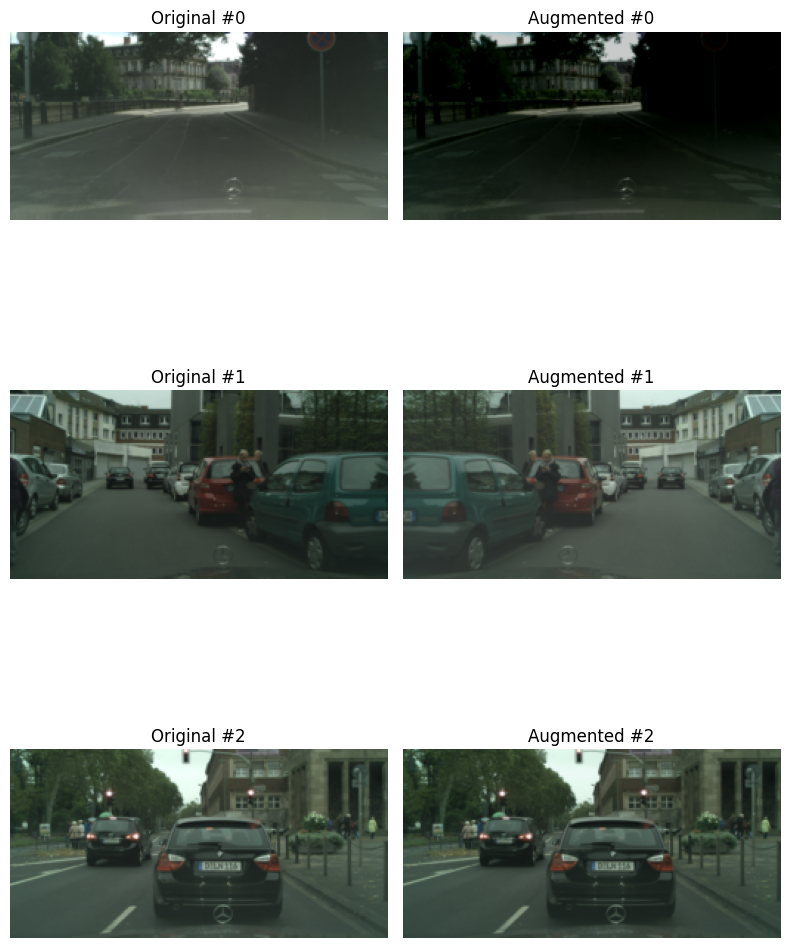

In [13]:
mean = np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
std  = np.array([0.229, 0.224, 0.225]).reshape(3,1,1)
def denorm(img_chw):
    img = img_chw * std + mean      
    img = np.clip(img, 0, 1)
    return np.transpose(img, (1,2,0))  

num_examples = 3
plt.figure(figsize=(8, 4 * num_examples))

for i in range(num_examples):
    img_t = train_images[i]        
    img   = img_t.cpu().numpy()
    aug_img, _ = augment_once(img, None)   
    orig_show = denorm(img)
    aug_show  = denorm(aug_img)
    plt.subplot(num_examples, 2, 2*i + 1)
    plt.imshow(orig_show)
    plt.title(f"Original #{i}")
    plt.axis("off")
    plt.subplot(num_examples, 2, 2*i + 2)
    plt.imshow(aug_show)
    plt.title(f"Augmented #{i}")  
    plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
# after the pre_processing data
print("Normalized train_images_t shape:", train_images.shape)
print("Normalized test_images_t shape:", test_images.shape)
print("Normalized valid_images_t shape:", val_images.shape)

Normalized train_images_t shape: torch.Size([2780, 3, 128, 256])
Normalized test_images_t shape: torch.Size([348, 3, 128, 256])
Normalized valid_images_t shape: torch.Size([347, 3, 128, 256])



For now, our dataset is ready to train our model. Next we will look at our model architecture.

# 4. Model Training
We compare a baseline SegFormer-B0 model (denoted as \textbf{Model 4.14}) 
with a label-smoothed version (denoted as \textbf{Model 4.14.2}).

## 4.1 Data loader

In [15]:
class CityscapesDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images     
        self.masks = masks          

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return {
            "pixel_values": self.images[idx],
            "labels": self.masks[idx],
        }

train_dataset = CityscapesDataset(train_images, train_masks)
val_dataset   = CityscapesDataset(val_images,   val_masks)
test_dataset   = CityscapesDataset(test_images,   test_masks)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  
#batchsize  = 8

val_loader   = DataLoader(val_dataset,   batch_size=8, shuffle=False)
test_loader   = DataLoader(test_dataset,   batch_size=8, shuffle=False)

## 4.2 Method1 (SegFormer)
Loading SegFormer model (19 classes) + Optimizer

In [16]:
num_labels = 19
id2label = {i: f"class_{i}" for i in range(num_labels)}
label2id = {v: k for k, v in id2label.items()}

checkpoint = "nvidia/segformer-b0-finetuned-ade-512-512"

config = SegformerConfig.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_index=-1, 

)

config.semantic_loss_ignore_index = -1 # cause the ignore label is -1 , just ignore it

model = SegformerForSemanticSegmentation.from_pretrained(checkpoint,config=config,
    ignore_mismatched_sizes=True,   
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([19]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([19, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4.2.1 train + val loss

In [17]:
def pixel_accuracy(preds, labels):
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

In [18]:
num_epochs = 200 # numner of epochs

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_acc = 0.0

    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=pixel_values, labels=labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        logits = outputs.logits
        if logits.shape[-2:] != labels.shape[-2:]:
            logits = F.interpolate(
                logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
        
        preds = logits.argmax(dim=1)
        total_train_acc += pixel_accuracy(preds, labels)

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_acc / len(train_loader)

    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

# Validation 
    model.eval()
    total_val_loss = 0.0
    total_val_acc = 0.0

    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, labels=labels)
            total_val_loss += outputs.loss.item()
            logits = outputs.logits
            if logits.shape[-2:] != labels.shape[-2:]:
                logits = F.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )

            preds = logits.argmax(dim=1)
            total_val_acc += pixel_accuracy(preds, labels)

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = total_val_acc / len(val_loader)

    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    
    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train loss: {avg_train_loss:.4f}, Train acc: {avg_train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val acc: {avg_val_acc:.4f}")


Epoch 1/200 Train loss: 1.3609, Train acc: 0.6623 | Val Loss: 0.7680, Val acc: 0.7287
Epoch 2/200 Train loss: 0.6799, Train acc: 0.7341 | Val Loss: 0.5734, Val acc: 0.7445
Epoch 3/200 Train loss: 0.5555, Train acc: 0.7482 | Val Loss: 0.5018, Val acc: 0.7539
Epoch 4/200 Train loss: 0.4921, Train acc: 0.7584 | Val Loss: 0.4520, Val acc: 0.7615
Epoch 5/200 Train loss: 0.4480, Train acc: 0.7657 | Val Loss: 0.4222, Val acc: 0.7666
Epoch 6/200 Train loss: 0.4157, Train acc: 0.7717 | Val Loss: 0.4018, Val acc: 0.7691
Epoch 7/200 Train loss: 0.3909, Train acc: 0.7757 | Val Loss: 0.3845, Val acc: 0.7724
Epoch 8/200 Train loss: 0.3710, Train acc: 0.7795 | Val Loss: 0.3676, Val acc: 0.7757
Epoch 9/200 Train loss: 0.3545, Train acc: 0.7827 | Val Loss: 0.3713, Val acc: 0.7728
Epoch 10/200 Train loss: 0.3384, Train acc: 0.7860 | Val Loss: 0.3522, Val acc: 0.7780
Epoch 11/200 Train loss: 0.3257, Train acc: 0.7890 | Val Loss: 0.3455, Val acc: 0.7792
Epoch 12/200 Train loss: 0.3143, Train acc: 0.7915 |

Epoch 96/200 Train loss: 0.1555, Train acc: 0.8287 | Val Loss: 0.3403, Val acc: 0.7912
Epoch 97/200 Train loss: 0.1564, Train acc: 0.8284 | Val Loss: 0.3462, Val acc: 0.7914
Epoch 98/200 Train loss: 0.1542, Train acc: 0.8290 | Val Loss: 0.3367, Val acc: 0.7918
Epoch 99/200 Train loss: 0.1537, Train acc: 0.8290 | Val Loss: 0.3416, Val acc: 0.7916
Epoch 100/200 Train loss: 0.1538, Train acc: 0.8291 | Val Loss: 0.3427, Val acc: 0.7918
Epoch 101/200 Train loss: 0.1522, Train acc: 0.8294 | Val Loss: 0.3451, Val acc: 0.7913
Epoch 102/200 Train loss: 0.1520, Train acc: 0.8296 | Val Loss: 0.3453, Val acc: 0.7912
Epoch 103/200 Train loss: 0.1523, Train acc: 0.8294 | Val Loss: 0.3463, Val acc: 0.7911
Epoch 104/200 Train loss: 0.1532, Train acc: 0.8291 | Val Loss: 0.3444, Val acc: 0.7914
Epoch 105/200 Train loss: 0.1512, Train acc: 0.8297 | Val Loss: 0.3478, Val acc: 0.7916
Epoch 106/200 Train loss: 0.1518, Train acc: 0.8297 | Val Loss: 0.3469, Val acc: 0.7916
Epoch 107/200 Train loss: 0.1491, Tr

Epoch 190/200 Train loss: 0.1261, Train acc: 0.8362 | Val Loss: 0.3813, Val acc: 0.7917
Epoch 191/200 Train loss: 0.1263, Train acc: 0.8361 | Val Loss: 0.3815, Val acc: 0.7914
Epoch 192/200 Train loss: 0.1260, Train acc: 0.8362 | Val Loss: 0.3838, Val acc: 0.7921
Epoch 193/200 Train loss: 0.1249, Train acc: 0.8365 | Val Loss: 0.3898, Val acc: 0.7914
Epoch 194/200 Train loss: 0.1265, Train acc: 0.8361 | Val Loss: 0.3825, Val acc: 0.7920
Epoch 195/200 Train loss: 0.1265, Train acc: 0.8361 | Val Loss: 0.3842, Val acc: 0.7924
Epoch 196/200 Train loss: 0.1245, Train acc: 0.8367 | Val Loss: 0.3873, Val acc: 0.7919
Epoch 197/200 Train loss: 0.1256, Train acc: 0.8362 | Val Loss: 0.3812, Val acc: 0.7917
Epoch 198/200 Train loss: 0.1251, Train acc: 0.8365 | Val Loss: 0.3876, Val acc: 0.7920
Epoch 199/200 Train loss: 0.1235, Train acc: 0.8369 | Val Loss: 0.3875, Val acc: 0.7916
Epoch 200/200 Train loss: 0.1243, Train acc: 0.8366 | Val Loss: 0.3875, Val acc: 0.7916


In [19]:
torch.save(model.state_dict(), "model_segformer.pth")

## 4.2.3 Visualizing results

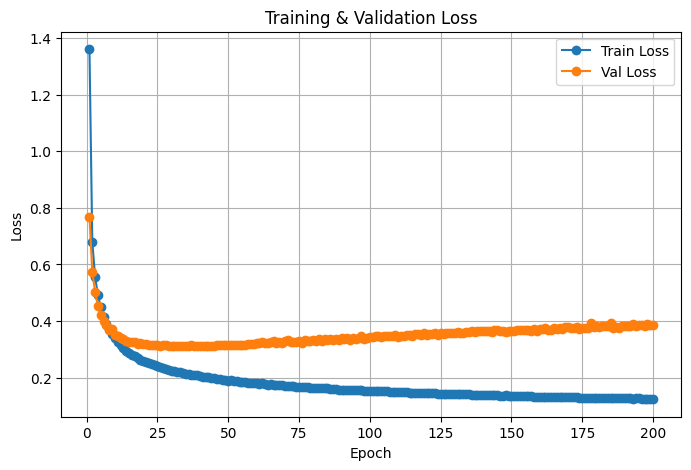

In [20]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8,5))

# Loss
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


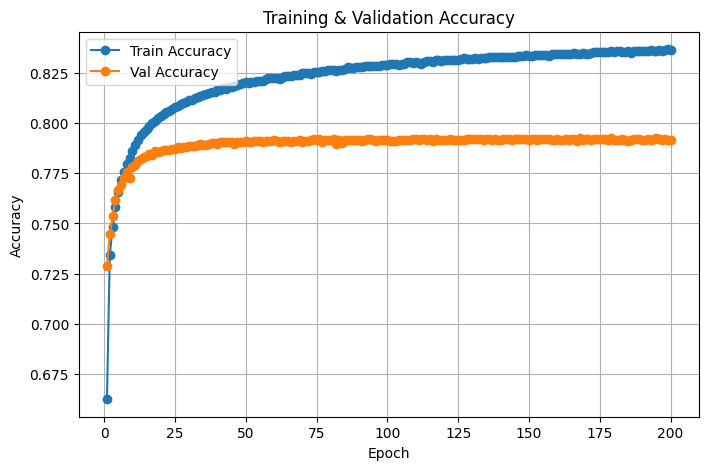

In [21]:
#accuracy

plt.figure(figsize=(8,5))
plt.plot(epochs, train_accs, marker='o', label='Train Accuracy')
plt.plot(epochs, val_accs, marker='o', label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

In [37]:
num_classes = 19   

y_true_all = []
y_pred_all = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)        

        outputs = model(pixel_values=pixel_values)

        logits = outputs.logits                  

    
        if logits.shape[-2:] != labels.shape[-2:]:
            logits = F.interpolate(
                logits,
                size=labels.shape[-2:], 
                mode="bilinear",
                align_corners=False
            )

        preds = logits.argmax(dim=1)           

        y_true_all.extend(labels.cpu().numpy().reshape(-1))
        y_pred_all.extend(preds.cpu().numpy().reshape(-1))

cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(num_classes)))

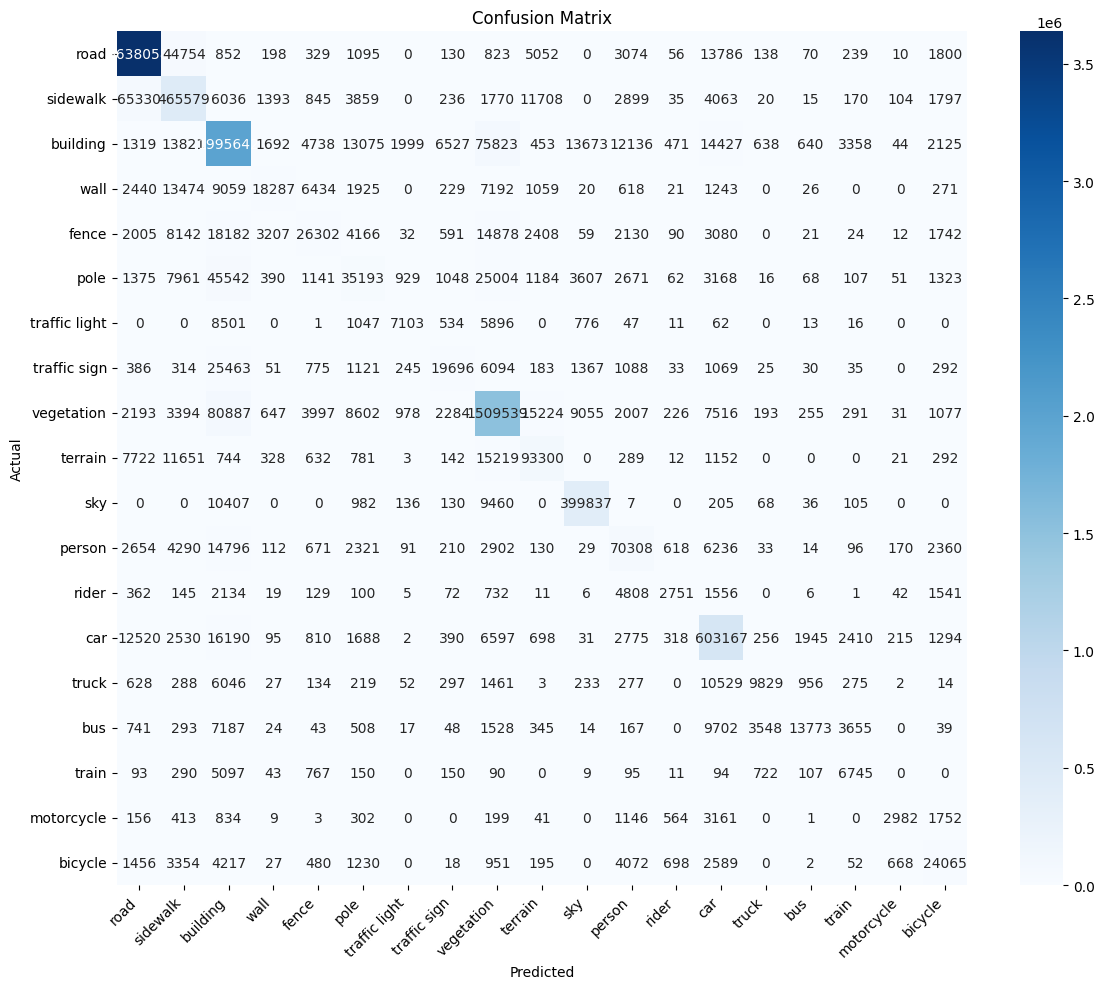

In [38]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    cmap="Blues",
    annot=True,            
    fmt="d",              
    xticklabels=cityscapes_classes,
    yticklabels=cityscapes_classes
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# plot compare to the GT

In [39]:
batch = next(iter(test_loader))

pixel_values = batch["pixel_values"].to(device)  
labels = batch["labels"].to(device)               

with torch.no_grad():
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits                       

    if logits.shape[-2:] != labels.shape[-2:]:
        logits = F.interpolate(
            logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

    preds = logits.argmax(dim=1)                 


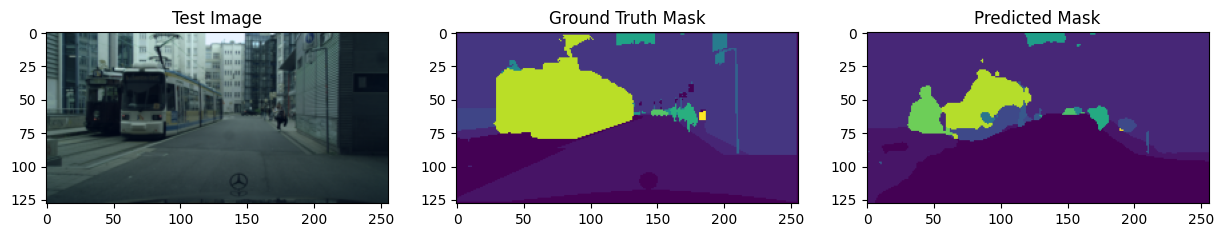

In [40]:
idx = 0

img = pixel_values[idx].cpu().permute(1,2,0).numpy()
img = (img - img.min()) / (img.max() - img.min())  

gt = labels[idx].cpu().numpy()
pred = preds[idx].cpu().numpy()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Test Image")

plt.subplot(1,3,2)
plt.imshow(gt)
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred)
plt.title("Predicted Mask")

plt.show()

In [41]:
def compute_iou(preds, labels, num_classes):
    preds = preds.cpu()
    labels = labels.cpu()
    
    ious = []
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        label_cls = (labels == cls)

        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()

        if union == 0:
            continue
        ious.append(intersection / union)

    if len(ious) == 0:
        return 0.0
    return sum(ious) / len(ious)

def evaluate_test_set(model, test_loader, device, num_classes):
    model.eval()
    total_iou = 0.0

    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            if logits.shape[-2:] != labels.shape[-2:]:  # Resize logits to match label size
                logits = torch.nn.functional.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )

            preds = logits.argmax(dim=1)

            batch_iou = compute_iou(preds, labels, num_classes)
            total_iou += batch_iou

    avg_iou = total_iou / len(test_loader)
    return avg_iou
NUM_CLASSES = 19  
test_miou = evaluate_test_set(model, test_loader, device, NUM_CLASSES)
print("Test set mIoU:", test_miou)


Test set mIoU: 0.3797452062357578


# 4.3 Method 2 (SegFormer(label-smoothed ))

In [42]:
num_labels = 19
id2label = {i: f"class_{i}" for i in range(num_labels)}
label2id = {v: k for k, v in id2label.items()}

checkpoint = "nvidia/segformer-b0-finetuned-ade-512-512"
config = SegformerConfig.from_pretrained(
    checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_index=-1,
)
config.semantic_loss_ignore_index = -1  
model_ls = SegformerForSemanticSegmentation.from_pretrained(
    checkpoint,
    config=config,
    ignore_mismatched_sizes=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ls.to(device)

optimizer = torch.optim.AdamW(model_ls.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss(
    ignore_index=-1,      
    label_smoothing=0.05,  
)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([19]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([19, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
num_epochs = 200  # number of epochs
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    model_ls.train()
    total_train_loss = 0.0
    total_train_acc = 0.0

    for batch in train_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model_ls(pixel_values=pixel_values)
        logits = outputs.logits  

        if logits.shape[-2:] != labels.shape[-2:]:
            logits = F.interpolate(
                logits,
                size=labels.shape[-2:],
                mode="bilinear",
                align_corners=False
            )
        loss = criterion(logits, labels) # sommyh loose

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        preds = logits.argmax(dim=1)
        total_train_acc += pixel_accuracy(preds, labels)  

    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_acc = total_train_acc / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

# ---------- Validation ---------- ---------- ---------- ---------- ---------- ---------- ----------
    model_ls.eval()
    total_val_loss = 0.0
    total_val_acc = 0.0

    with torch.no_grad():
        for batch in val_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            outputs = model_ls(pixel_values=pixel_values)
            logits = outputs.logits
            if logits.shape[-2:] != labels.shape[-2:]:
                logits = F.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )
            loss = criterion(logits, labels)
            total_val_loss += loss.item()

            preds = logits.argmax(dim=1)
            
            total_val_acc += pixel_accuracy(preds, labels)

            
    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_acc = total_val_acc / len(val_loader)

    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)

    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"Train loss: {avg_train_loss:.4f}, Train acc: {avg_train_acc:.4f} | "
        f"Val Loss: {avg_val_loss:.4f}, Val acc: {avg_val_acc:.4f}"
    )

Epoch 1/200 Train loss: 1.4604, Train acc: 0.6643 | Val Loss: 0.9305, Val acc: 0.7286
Epoch 2/200 Train loss: 0.8755, Train acc: 0.7356 | Val Loss: 0.7965, Val acc: 0.7448
Epoch 3/200 Train loss: 0.7804, Train acc: 0.7510 | Val Loss: 0.7337, Val acc: 0.7574
Epoch 4/200 Train loss: 0.7342, Train acc: 0.7612 | Val Loss: 0.6993, Val acc: 0.7649
Epoch 5/200 Train loss: 0.7023, Train acc: 0.7685 | Val Loss: 0.6842, Val acc: 0.7677
Epoch 6/200 Train loss: 0.6787, Train acc: 0.7736 | Val Loss: 0.6684, Val acc: 0.7713
Epoch 7/200 Train loss: 0.6609, Train acc: 0.7779 | Val Loss: 0.6560, Val acc: 0.7747
Epoch 8/200 Train loss: 0.6447, Train acc: 0.7822 | Val Loss: 0.6467, Val acc: 0.7769
Epoch 9/200 Train loss: 0.6336, Train acc: 0.7850 | Val Loss: 0.6400, Val acc: 0.7786
Epoch 10/200 Train loss: 0.6221, Train acc: 0.7884 | Val Loss: 0.6339, Val acc: 0.7802
Epoch 11/200 Train loss: 0.6118, Train acc: 0.7910 | Val Loss: 0.6326, Val acc: 0.7801
Epoch 12/200 Train loss: 0.6056, Train acc: 0.7928 |

Epoch 96/200 Train loss: 0.4836, Train acc: 0.8270 | Val Loss: 0.6063, Val acc: 0.7914
Epoch 97/200 Train loss: 0.4825, Train acc: 0.8275 | Val Loss: 0.6084, Val acc: 0.7908
Epoch 98/200 Train loss: 0.4832, Train acc: 0.8272 | Val Loss: 0.6050, Val acc: 0.7915
Epoch 99/200 Train loss: 0.4815, Train acc: 0.8276 | Val Loss: 0.6052, Val acc: 0.7920
Epoch 100/200 Train loss: 0.4837, Train acc: 0.8269 | Val Loss: 0.6065, Val acc: 0.7913
Epoch 101/200 Train loss: 0.4813, Train acc: 0.8277 | Val Loss: 0.6066, Val acc: 0.7915
Epoch 102/200 Train loss: 0.4805, Train acc: 0.8281 | Val Loss: 0.6048, Val acc: 0.7917
Epoch 103/200 Train loss: 0.4803, Train acc: 0.8280 | Val Loss: 0.6059, Val acc: 0.7919
Epoch 104/200 Train loss: 0.4794, Train acc: 0.8283 | Val Loss: 0.6063, Val acc: 0.7918
Epoch 105/200 Train loss: 0.4789, Train acc: 0.8284 | Val Loss: 0.6057, Val acc: 0.7917
Epoch 106/200 Train loss: 0.4799, Train acc: 0.8280 | Val Loss: 0.6050, Val acc: 0.7920
Epoch 107/200 Train loss: 0.4791, Tr

Epoch 190/200 Train loss: 0.4586, Train acc: 0.8342 | Val Loss: 0.6124, Val acc: 0.7920
Epoch 191/200 Train loss: 0.4580, Train acc: 0.8346 | Val Loss: 0.6134, Val acc: 0.7918
Epoch 192/200 Train loss: 0.4583, Train acc: 0.8344 | Val Loss: 0.6140, Val acc: 0.7918
Epoch 193/200 Train loss: 0.4591, Train acc: 0.8341 | Val Loss: 0.6138, Val acc: 0.7919
Epoch 194/200 Train loss: 0.4589, Train acc: 0.8343 | Val Loss: 0.6116, Val acc: 0.7917
Epoch 195/200 Train loss: 0.4594, Train acc: 0.8341 | Val Loss: 0.6131, Val acc: 0.7918
Epoch 196/200 Train loss: 0.4587, Train acc: 0.8343 | Val Loss: 0.6117, Val acc: 0.7923
Epoch 197/200 Train loss: 0.4585, Train acc: 0.8343 | Val Loss: 0.6141, Val acc: 0.7917
Epoch 198/200 Train loss: 0.4576, Train acc: 0.8346 | Val Loss: 0.6132, Val acc: 0.7920
Epoch 199/200 Train loss: 0.4579, Train acc: 0.8345 | Val Loss: 0.6107, Val acc: 0.7925
Epoch 200/200 Train loss: 0.4578, Train acc: 0.8345 | Val Loss: 0.6134, Val acc: 0.7917


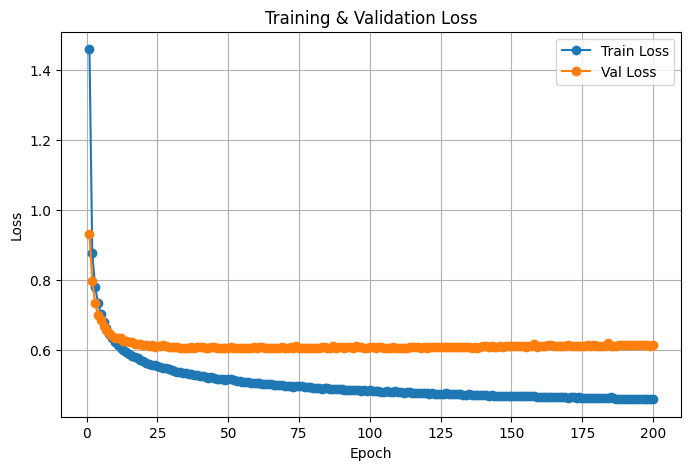

In [44]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8,5))

# Loss
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

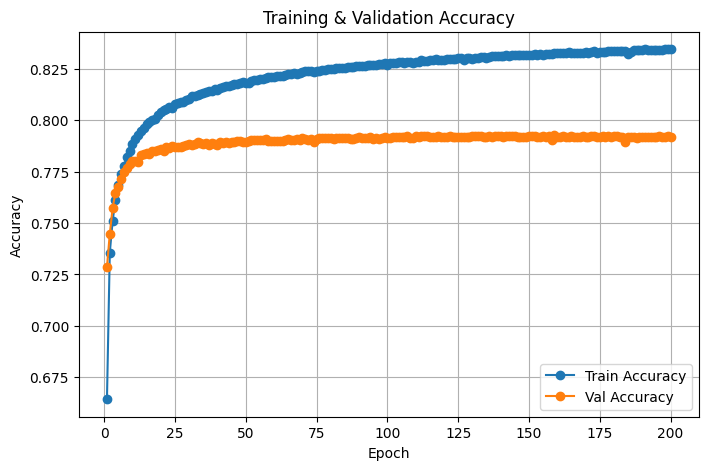

In [45]:
#accuracy
plt.figure(figsize=(8,5))
plt.plot(epochs, train_accs, marker='o', label='Train Accuracy')
plt.plot(epochs, val_accs, marker='o', label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

## 4.3.2 Visualizing results¶

In [46]:
num_classes = 19   

y_true_all = []
y_pred_all = []

model_ls.eval()
with torch.no_grad():
    for batch in test_loader:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)        

        outputs = model_ls(pixel_values=pixel_values)

        logits = outputs.logits                  

    
        if logits.shape[-2:] != labels.shape[-2:]:
            logits = F.interpolate(
                logits,
                size=labels.shape[-2:], 
                mode="bilinear",
                align_corners=False)
        preds = logits.argmax(dim=1)           

        y_true_all.extend(labels.cpu().numpy().reshape(-1))
        y_pred_all.extend(preds.cpu().numpy().reshape(-1))

cm = confusion_matrix(y_true_all, y_pred_all, labels=list(range(num_classes)))

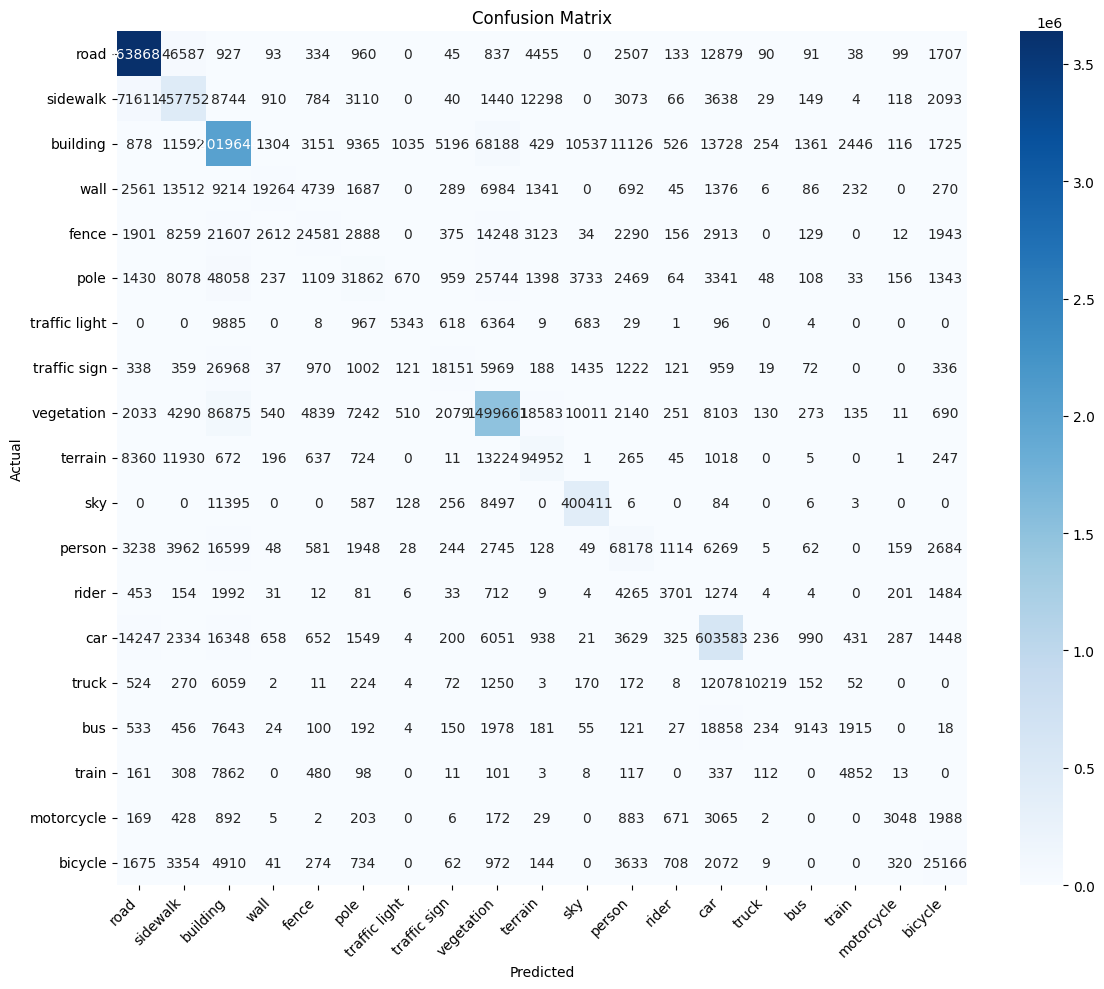

In [47]:
plt.figure(figsize=(12, 10))

sns.heatmap(
    cm,
    cmap="Blues",
    annot=True,            
    fmt="d",              
    xticklabels=cityscapes_classes,
    yticklabels=cityscapes_classes
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [48]:
batch = next(iter(test_loader))

pixel_values = batch["pixel_values"].to(device)  
labels = batch["labels"].to(device)               

with torch.no_grad():
    outputs = model_ls(pixel_values=pixel_values)
    logits = outputs.logits                       

    if logits.shape[-2:] != labels.shape[-2:]:
        logits = F.interpolate(
            logits,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

    preds = logits.argmax(dim=1)                 

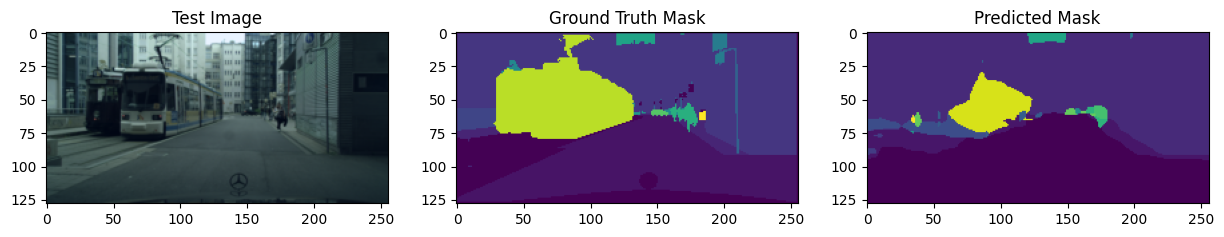

In [49]:
idx = 0
img = pixel_values[idx].cpu().permute(1,2,0).numpy()
img = (img - img.min()) / (img.max() - img.min())  

gt = labels[idx].cpu().numpy()
pred = preds[idx].cpu().numpy()

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Test Image")

plt.subplot(1,3,2)
plt.imshow(gt)
plt.title("Ground Truth Mask")

plt.subplot(1,3,3)
plt.imshow(pred)
plt.title("Predicted Mask")

plt.show()

In [50]:
def compute_iou(preds, labels, num_classes):
    preds = preds.cpu()
    labels = labels.cpu()
    
    ious = []
    for cls in range(num_classes):
        pred_cls = (preds == cls)
        label_cls = (labels == cls)

        intersection = (pred_cls & label_cls).sum().item()
        union = (pred_cls | label_cls).sum().item()

        if union == 0:
            continue
        ious.append(intersection / union)
    if len(ious) == 0:
        return 0.0
    return sum(ious) / len(ious)

def evaluate_test_set(model_ls, test_loader, device, num_classes):
    model_ls.eval()
    total_iou = 0.0

    with torch.no_grad():
        for batch in test_loader:
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model_ls(pixel_values=pixel_values)
            logits = outputs.logits

            # Resize logits to match label size
            if logits.shape[-2:] != labels.shape[-2:]:
                logits = torch.nn.functional.interpolate(
                    logits,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False
                )
            preds = logits.argmax(dim=1)

            batch_iou = compute_iou(preds, labels, num_classes)
            total_iou += batch_iou

    avg_iou = total_iou / len(test_loader)
    return avg_iou
NUM_CLASSES = 19  

test_miou = evaluate_test_set(model_ls, test_loader, device, NUM_CLASSES)
print("Test set mIoU:", test_miou)

Test set mIoU: 0.38377599215437375


# Finish ！！！